# ML project: prediction

In this Machine learning project, our purpose is to predict who's going to be the MVP and given the winner of the NBA Season

## Part1 : Web Scraping NBA stats
### 1-Downloading MVP votes with requests 

In [104]:
import requests
years = list(range(1991,2022))

url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

In [110]:
for year in years:
    url = url_start.format(year)
    data = requests.get(url)
    with open("mvp/{}.html".format(year), "w+") as f:
         f.write(data.text)

### 2- Parsing the votes table with beautifulSoup

In [108]:
from bs4 import BeautifulSoup
import pandas as pd

dfs = []
for year in years:
    with open("mvp/{}.html".format(year)) as f :
        page = f.read()
    soup = BeautifulSoup(page, "html.parser")
    #print(year)
    soup.find("tr", class_="over_header").decompose()
    mvp_table = soup.find_all(id="mvp")
    mvp = pd.read_html(str(mvp_table))[0]
    mvp["Year"] = year
    dfs.append(mvp)

## we have a list of dataframe
dfs[0]

AttributeError: 'NoneType' object has no attribute 'decompose'

### 3- Combining MVP votes with pandas

In [ ]:
mvps = pd.concat(dfs)
mvps.tail()

In [ ]:
# store in a csv file
mvps.to_csv("mvps.csv")

Now to better train our model, we should use all the players stats in the different years

### 4- Downloading players stats

In [ ]:
player_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
year = 1991
url = player_stats_url.format(year)
data = requests.get(url)
with open("player/1991.html","w+") as f:
    f.write(data.text)

We are not getting all the data because the real page use javascript to fetch the remaining data.

### 5- Using selenium to scrape a javascript page


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

service = Service(executable_path="/Users/biad/development/chromedriver")
driver = webdriver.Chrome(service = service)

In [ ]:
import time 
driver.get(url)
driver.execute_script("window.scrollTo(1,10000)")
time.sleep(2)
# get all the stats for one year
html = driver.page_source

In [ ]:
with open("player/{}".format(year), "w+") as f:
    f.write(html)

In [ ]:
# Apply to the years
for year in years :
    url = player_stats_url.format(year)
    driver.get(url)
    driver.execute_script("window.scrollTo(1,10000)")
    time.sleep(2)
    # get all the stats for one year
    html = driver.page_source
    with open("player/{}.html".format(year), "w+") as f:
        f.write(html)
    

### 6- Parsing the stats with beautifulSoup

In [ ]:

stats = []
for year in years :
    with open("player/{}.html".format(year)) as f:
         page = f.read()
         soup = BeautifulSoup(page, "html.parser")
         soup.find('tr', class_="thead").decompose()
         player_stats = soup.find(id="per_game_stats")
         players = pd.read_html(str(player_stats))[0]
         players["Year"] = year
    stats.append(players)

stats[0].head()

### 7- Combining player stats with Pandas



In [ ]:
players = pd.concat(stats)
players.shape

In [ ]:
players.to_csv("players.csv")

### 8- Download team data

In [ ]:
team_stat_url = "https://www.basketball-reference.com/leagues/NBA_{}_standings.html"
for year in years:
    url = team_stat_url.format(year)
    data = requests.get(url)
    with open("team/{}.html".format(year), "w+") as f:
        f.write(data.text)

### 9- Parsing the team data with beautifulSoup and combining with pandas

In [ ]:
dfs = []
for year in years:
    with open("team/{}.html".format(year)) as f :
        page = f.read()
        soup = BeautifulSoup(page, "html.parser")
        soup.find("tr", class_="thead").decompose()
        team_table = soup.find(id="divs_standings_E")
        team = pd.read_html(str(team_table))[0]
        team["Year"]= year
        team["Team"] = team["Eastern Conference"]
        del team["Eastern Conference"]
        dfs.append(team)

        soup = BeautifulSoup(page, "html.parser")
        soup.find("tr", class_="thead").decompose()
        team_table = soup.find(id="divs_standings_W")
        team = pd.read_html(str(team_table))[0]
        team["Year"]= year
        team["Team"] = team["Western Conference"]
        del team["Western Conference"]
        dfs.append(team)


teams = pd.concat(dfs)
teams.head()

In [ ]:
teams.to_csv("teams.csv")

## Part2: Cleaning NBA Stats
### 1- Cleaning the MVP vote data 

In [5]:
import pandas as pd
mvps = pd.read_csv("mvps.csv")
mvps.head()

ModuleNotFoundError: No module named 'pandas'

In [116]:
mvps = mvps[["Player","Year","Pts Won","Pts Max","Share"]]
mvps.head()

,Player,Year,Pts Won,Pts Max,Share
0,Michael Jordan,1991,891.0,960,0.928
1,Magic Johnson,1991,497.0,960,0.518
2,David Robinson,1991,476.0,960,0.496
3,Charles Barkley,1991,222.0,960,0.231
4,Karl Malone,1991,142.0,960,0.148


### 2- Cleaning the player data

In [131]:
players = pd.read_csv("players.csv")
players.head()

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,0,1,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,...,0.6,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,1991
1,1,2,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,...,0.5,1.3,1.8,3.1,0.8,0.1,1.6,2.2,14.1,1991
2,2,3,Mark Acres,C,28,ORL,68,0,19.3,1.6,...,2.1,3.2,5.3,0.4,0.4,0.4,0.6,3.2,4.2,1991
3,3,4,Michael Adams,PG,28,DEN,66,66,35.5,8.5,...,0.9,3.0,3.9,10.5,2.2,0.1,3.6,2.5,26.5,1991
4,4,5,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,...,1.7,3.1,4.8,1.8,0.6,0.3,1.6,2.7,14.2,1991


In [132]:
del players["Unnamed: 0"]
del players["Rk"]
players = players[~(players["Age"]=="Age")]

In [133]:
# to delete the * in the name of players 
players["Player"] = players["Player"].str.replace("*","",regex=False)

In [134]:
def single_row(df):
    if df.shape[0] == 1 :
        return df
    else:
        row = df[df["Tm"] == df.iloc[0]["Tm"]]
        row["Tm"] = df.iloc[-1,:]["Tm"]
        return row

players = players.groupby(["Player","Year"]).apply(single_row)
players.head(20)

Player Pos Age   Tm   G  GS    MP   FG   FGA  \
Player        Year                                                              
A.C. Green    1991 164       A.C. Green  PF  27  LAL  82  21  26.4  3.1   6.6   
              1992 633       A.C. Green  PF  28  LAL  82  53  35.4  4.7   9.8   
              1993 1092      A.C. Green  PF  29  LAL  82  55  34.4  4.6   8.6   
              1994 1579      A.C. Green  PF  30  PHO  82  55  34.5  5.7  11.3   
              1995 2067      A.C. Green  SF  31  PHO  82  52  32.8  3.8   7.5   
              1996 2563      A.C. Green  SF  32  PHO  82  36  25.8  2.6   5.4   
              1997 3138      A.C. Green  PF  33  DAL  83  73  30.0  2.8   5.8   
              1998 3725      A.C. Green  PF  34  DAL  82  68  32.3  3.0   6.5   
              1999 4283      A.C. Green  PF  35  DAL  50  35  18.5  2.2   5.1   
              2000 4811      A.C. Green  PF  36  LAL  82  82  23.5  2.1   4.7   
              2001 5330      A.C. Green  PF  37  MIA  82   1  17.2  1.8   4.0   
A.J. Bramlett 2000 4684   A.J. Bramlett   C  23  CLE   8   0   7.6  0.5   2.6   
A.J. English  1991 127     A.J. English  SG  23  WSB  70  12  20.6  3.6   8.2   
              1992 597     A.J. English  SG  24  WSB  81   6  20.6  4.5  10.4   
A.J. Guyton   2001 5333     A.J. Guyton  PG  22  CHI  33   8  19.1  2.4   5.8   
              2002 5886     A.J. Guyton  PG  23  CHI  45   6  13.5  2.0   5.4   
              2003 6393     A.J. Guyton  PG  24  GSW   2   0   4.5  0.0   2.0   
A.J. Hammons  2017 14814   A.J. Hammons   C  24  DAL  22   0   7.4  0.8   1.9   
A.J. Price    2010 10727     A.J. Price  PG  23  IND  56   2  15.4  2.6   6.3   
              2011 11356     A.J. Price  PG  24  IND  50   0  15.9  2.3   6.4   

                           FG%  ...  ORB  DRB  TRB  AST  STL  BLK  TOV   PF  \
Player        Year              ...                                           
A.C. Green    1991 164    .476  ...  2.5  3.8  6.3  0.9  0.7  0.3  1.2  1.4   
              1992 633    .476  ...  3.7  5.6  9.3  1.4  1.1  0.4  1.4  1.7   
              1993 1092   .537  ...  3.5  5.2  8.7  1.4  1.1  0.5  1.4  1.8   
              1994 1579   .502  ...  3.4  5.8  9.2  1.7  0.9  0.5  1.2  1.7   
              1995 2067   .504  ...  2.4  5.8  8.2  1.5  0.7  0.4  1.4  1.8   
              1996 2563   .484  ...  2.0  4.7  6.8  0.9  0.5  0.3  1.0  1.7   
              1997 3138   .483  ...  2.7  5.2  7.9  0.8  0.8  0.2  0.9  1.7   
              1998 3725   .453  ...  2.7  5.5  8.1  1.5  1.0  0.3  0.8  1.9   
              1999 4283   .422  ...  1.6  2.9  4.6  0.5  0.6  0.2  0.4  1.4   
              2000 4811   .447  ...  2.0  4.0  5.9  1.0  0.6  0.2  0.6  1.5   
              2001 5330   .444  ...  1.3  2.5  3.8  0.5  0.4  0.1  0.5  1.5   
A.J. Bramlett 2000 4684   .190  ...  1.5  1.3  2.8  0.0  0.1  0.0  0.4  1.6   
A.J. English  1991 127    .439  ...  0.9  1.2  2.1  2.5  0.4  0.2  1.6  1.8   
              1992 597    .433  ...  0.9  1.2  2.1  1.8  0.4  0.1  1.1  2.0   
A.J. Guyton   2001 5333   .406  ...  0.3  0.8  1.1  1.9  0.3  0.2  0.7  1.1   
              2002 5886   .361  ...  0.3  0.7  1.0  1.8  0.2  0.2  0.8  0.5   
              2003 6393   .000  ...  0.0  0.0  0.0  1.0  0.5  0.0  0.5  0.0   
A.J. Hammons  2017 14814  .405  ...  0.4  1.3  1.6  0.2  0.0  0.6  0.5  1.0   
A.J. Price    2010 10727  .410  ...  0.2  1.4  1.6  1.9  0.6  0.1  1.1  0.9   
              2011 11356  .356  ...  0.3  1.1  1.4  2.2  0.6  0.0  1.1  1.2   

                           PTS  Year  
Player        Year                    
A.C. Green    1991 164     9.1  1991  
              1992 633    13.6  1992  
              1993 1092   12.8  1993  
              1994 1579   14.7  1994  
              1995 2067   11.2  1995  
              1996 2563    7.5  1996  
              1997 3138    7.2  1997  
              1998 3725    7.3  1998  
              1999 4283    4.9  1999  
              2000 4811    5.0  2000  
              2001 5330    4.5  2001  
A.J.

In [135]:
players.index = players.index.droplevel()
players.index = players.index.droplevel()
players.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
164,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,.476,...,2.5,3.8,6.3,0.9,0.7,0.3,1.2,1.4,9.1,1991
633,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,.476,...,3.7,5.6,9.3,1.4,1.1,0.4,1.4,1.7,13.6,1992
1092,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,.537,...,3.5,5.2,8.7,1.4,1.1,0.5,1.4,1.8,12.8,1993
1579,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,.502,...,3.4,5.8,9.2,1.7,0.9,0.5,1.2,1.7,14.7,1994
2067,A.C. Green,SF,31,PHO,82,52,32.8,3.8,7.5,.504,...,2.4,5.8,8.2,1.5,0.7,0.4,1.4,1.8,11.2,1995
2563,A.C. Green,SF,32,PHO,82,36,25.8,2.6,5.4,.484,...,2.0,4.7,6.8,0.9,0.5,0.3,1.0,1.7,7.5,1996
3138,A.C. Green,PF,33,DAL,83,73,30.0,2.8,5.8,.483,...,2.7,5.2,7.9,0.8,0.8,0.2,0.9,1.7,7.2,1997
3725,A.C. Green,PF,34,DAL,82,68,32.3,3.0,6.5,.453,...,2.7,5.5,8.1,1.5,1.0,0.3,0.8,1.9,7.3,1998
4283,A.C. Green,PF,35,DAL,50,35,18.5,2.2,5.1,.422,...,1.6,2.9,4.6,0.5,0.6,0.2,0.4,1.4,4.9,1999
4811,A.C. Green,PF,36,LAL,82,82,23.5,2.1,4.7,.447,...,2.0,4.0,5.9,1.0,0.6,0.2,0.6,1.5,5.0,2000


### 3- Combining the player and MVP data

In [136]:
combined = players.merge(mvps, how="outer", on=["Player","Year"])
combined.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,NaN,NaN,NaN
1,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,NaN,NaN,NaN
2,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,NaN,NaN,NaN
3,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,NaN,NaN,NaN
4,A.C. Green,SF,31,PHO,82,52,32.8,3.8,7.5,.504,...,1.5,0.7,0.4,1.4,1.8,11.2,1995,NaN,NaN,NaN


In [137]:
combined[combined["Pts Won"]>0]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
187,Al Jefferson,C,29,CHA,73,73,35.0,9.6,18.8,.509,...,2.1,0.9,1.1,1.7,2.4,21.8,2014,34.0,1250.0,0.027
329,Allen Iverson,PG,21,PHI,76,74,40.1,8.2,19.8,.416,...,7.5,2.1,0.3,4.4,3.1,23.5,1997,1.0,1150.0,0.001
331,Allen Iverson,SG,23,PHI,48,48,41.5,9.1,22.0,.412,...,4.6,2.3,0.1,3.5,2.0,26.8,1999,319.0,1180.0,0.270
332,Allen Iverson,SG,24,PHI,70,70,40.8,10.4,24.8,.421,...,4.7,2.1,0.1,3.3,2.3,28.4,2000,132.0,1210.0,0.109
333,Allen Iverson,SG,25,PHI,71,71,42.0,10.7,25.5,.420,...,4.6,2.5,0.3,3.3,2.1,31.1,2001,1121.0,1240.0,0.904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13592,Vince Carter,SF,23,TOR,82,82,38.1,9.6,20.7,.465,...,3.9,1.3,1.1,2.2,3.2,25.7,2000,51.0,1210.0,0.042
13593,Vince Carter,SF,24,TOR,75,75,39.7,10.2,22.1,.460,...,3.9,1.5,1.1,2.2,2.7,27.6,2001,7.0,1240.0,0.006
13597,Vince Carter,SF-SG,28,NJN,77,76,36.7,9.0,20.0,.452,...,4.2,1.4,0.6,2.2,3.2,24.5,2005,3.0,1270.0,0.002
13957,Yao Ming,C,23,HOU,82,82,32.8,6.5,12.5,.522,...,1.5,0.3,1.9,2.5,3.3,17.5,2004,1.0,1230.0,0.001


In [138]:
# fix NaN value
combined[["Pts Won","Pts Max","Share"]] = combined[["Pts Won","Pts Max","Share"]].fillna(0)

In [139]:
combined.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,0.0,0.0,0.0
1,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,0.0,0.0,0.0
2,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,0.0,0.0,0.0
3,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,0.0,0.0,0.0
4,A.C. Green,SF,31,PHO,82,52,32.8,3.8,7.5,.504,...,1.5,0.7,0.4,1.4,1.8,11.2,1995,0.0,0.0,0.0


### 4- Cleaning the team data

In [140]:
teams = pd.read_csv("teams.csv")
teams.head(30)

,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics*
1,1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers*
2,2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks*
3,3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets
5,5,24,58,.293,32.0,101.8,107.8,-5.91,1991,Miami Heat
6,6,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,1991,Central Division
7,7,61,21,.744,—,110.0,101.0,8.57,1991,Chicago Bulls*
8,8,50,32,.610,11.0,100.1,96.8,3.08,1991,Detroit Pistons*
9,9,48,34,.585,13.0,106.4,104.0,2.33,1991,Milwaukee Bucks*


In [141]:
# let's remove rows with Division
teams = teams[~teams["W"].str.contains("Division")]
teams.head(30)

,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics*
1,1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers*
2,2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks*
3,3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets
5,5,24,58,.293,32.0,101.8,107.8,-5.91,1991,Miami Heat
7,7,61,21,.744,—,110.0,101.0,8.57,1991,Chicago Bulls*
8,8,50,32,.610,11.0,100.1,96.8,3.08,1991,Detroit Pistons*
9,9,48,34,.585,13.0,106.4,104.0,2.33,1991,Milwaukee Bucks*
10,10,43,39,.524,18.0,109.8,109.0,0.72,1991,Atlanta Hawks*


In [142]:
teams["Team"] = teams["Team"].str.replace("*","",regex=False)
teams.head()

,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics
1,1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers
2,2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks
3,3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets


In [143]:
print(teams["Team"].unique())
print("\n")
print(combined["Tm"].unique())

['Boston Celtics' 'Philadelphia 76ers' 'New York Knicks'
 'Washington Bullets' 'New Jersey Nets' 'Miami Heat' 'Chicago Bulls'
 'Detroit Pistons' 'Milwaukee Bucks' 'Atlanta Hawks' 'Indiana Pacers'
 'Cleveland Cavaliers' 'Charlotte Hornets' 'San Antonio Spurs' 'Utah Jazz'
 'Houston Rockets' 'Orlando Magic' 'Minnesota Timberwolves'
 'Dallas Mavericks' 'Denver Nuggets' 'Portland Trail Blazers'
 'Los Angeles Lakers' 'Phoenix Suns' 'Golden State Warriors'
 'Seattle SuperSonics' 'Los Angeles Clippers' 'Sacramento Kings'
 'Toronto Raptors' 'Vancouver Grizzlies' 'Washington Wizards'
 'Memphis Grizzlies' 'New Orleans Hornets' 'Charlotte Bobcats'
 'New Orleans/Oklahoma City Hornets' 'Oklahoma City Thunder'
 'Brooklyn Nets' 'New Orleans Pelicans']


['LAL' 'PHO' 'DAL' 'MIA' 'CLE' 'WSB' 'CHI' 'GSW' 'IND' 'WAS' 'MIN' 'BOS'
 'HOU' 'DEN' 'ORL' 'NOH' 'TOR' 'SAC' 'CHO' 'POR' 'DET' 'PHI' 'UTA' 'MIL'
 'VAN' 'SEA' 'NJN' 'NOK' 'LAC' 'OKC' 'ATL' 'CHA' 'MEM' 'NYK' 'NOP' 'BRK'
 'SAS' 'CHH']


In [144]:
nicknames = {}
with open("nicknames.txt") as f:
    lines = f.readlines()
    for line in lines[1:]:
        abbrev, name = line.replace("\n","").split(",")
        nicknames[abbrev] = name
nicknames

{'ATL': 'Atlanta Hawks',
 'BRK': 'Brooklyn Nets',
 'BKN': 'Brooklyn Nets',
 'BOS': 'Boston Celtics',
 'CHA': 'Charlotte Bobcats',
 'CHH': 'Charlotte Hornets',
 'CHO': 'Charlotte Hornets',
 'CHI': 'Chicago Bulls',
 'CLE': 'Cleveland Cavaliers',
 'DAL': 'Dallas Mavericks',
 'DEN': 'Denver Nuggets',
 'DET': 'Detroit Pistons',
 'GSW': 'Golden State Warriors',
 'HOU': 'Houston Rockets',
 'IND': 'Indiana Pacers',
 'LAC': 'Los Angeles Clippers',
 'LAL': 'Los Angeles Lakers',
 'MEM': 'Memphis Grizzlies',
 'MIA': 'Miami Heat',
 'MIL': 'Milwaukee Bucks',
 'MIN': 'Minnesota Timberwolves',
 'NJN': 'New Jersey Nets',
 'NOH': 'New Orleans Hornets',
 'NOP': 'New Orleans Pelicans',
 'NOK': 'New Orleans/Oklahoma City Hornets',
 'NYK': 'New York Knicks',
 'OKC': 'Oklahoma City Thunder',
 'ORL': 'Orlando Magic',
 'PHI': 'Philadelphia 76ers',
 'PHX': 'Phoenix Suns',
 'PHO': 'Phoenix Suns',
 'POR': 'Portland Trail Blazers',
 'SEA': 'Seattle SuperSonics',
 'SAC': 'Sacramento Kings',
 'SAS': 'San Antonio Spu

In [145]:
combined["Team"] = combined["Tm"].map(nicknames)
del combined["Tm"]
combined.head()

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share,Team
0,A.C. Green,PF,27,82,21,26.4,3.1,6.6,.476,0.1,...,0.7,0.3,1.2,1.4,9.1,1991,0.0,0.0,0.0,Los Angeles Lakers
1,A.C. Green,PF,28,82,53,35.4,4.7,9.8,.476,0.1,...,1.1,0.4,1.4,1.7,13.6,1992,0.0,0.0,0.0,Los Angeles Lakers
2,A.C. Green,PF,29,82,55,34.4,4.6,8.6,.537,0.2,...,1.1,0.5,1.4,1.8,12.8,1993,0.0,0.0,0.0,Los Angeles Lakers
3,A.C. Green,PF,30,82,55,34.5,5.7,11.3,.502,0.1,...,0.9,0.5,1.2,1.7,14.7,1994,0.0,0.0,0.0,Phoenix Suns
4,A.C. Green,SF,31,82,52,32.8,3.8,7.5,.504,0.5,...,0.7,0.4,1.4,1.8,11.2,1995,0.0,0.0,0.0,Phoenix Suns


In [146]:
stats = combined.merge(teams, how="outer", on=["Team","Year"])
stats

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,Share,Team,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,27,82,21,26.4,3.1,6.6,.476,0.1,...,0.0,Los Angeles Lakers,10,58,24,.707,5.0,106.3,99.6,6.73
1,Byron Scott,SG,29,82,82,32.1,6.1,12.8,.477,0.9,...,0.0,Los Angeles Lakers,10,58,24,.707,5.0,106.3,99.6,6.73
2,Elden Campbell,PF,22,52,0,7.3,1.1,2.4,.455,0.0,...,0.0,Los Angeles Lakers,10,58,24,.707,5.0,106.3,99.6,6.73
3,Irving Thomas,PF,25,26,0,4.2,0.7,1.9,.340,0.0,...,0.0,Los Angeles Lakers,10,58,24,.707,5.0,106.3,99.6,6.73
4,James Worthy,SF,29,78,74,38.6,9.2,18.7,.492,0.3,...,0.0,Los Angeles Lakers,10,58,24,.707,5.0,106.3,99.6,6.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092,Spencer Hawes,PF,28,54,1,14.8,2.5,5.1,.484,0.5,...,0.0,Milwaukee Bucks,7,42,40,.512,9.0,103.6,103.8,-0.45
14093,Steve Novak,PF,33,8,0,2.8,0.3,0.9,.286,0.1,...,0.0,Milwaukee Bucks,7,42,40,.512,9.0,103.6,103.8,-0.45
14094,Terrence Jones,PF,25,54,12,23.5,4.3,9.1,.470,0.4,...,0.0,Milwaukee Bucks,7,42,40,.512,9.0,103.6,103.8,-0.45
14095,Thon Maker,C,19,57,34,9.9,1.5,3.2,.459,0.5,...,0.0,Milwaukee Bucks,7,42,40,.512,9.0,103.6,103.8,-0.45


In [147]:
# let's delete some rows
del stats["Unnamed: 0"]

In [148]:
stats.dtypes

Player      object
Pos         object
Age         object
G           object
GS          object
MP          object
FG          object
FGA         object
FG%         object
3P          object
3PA         object
3P%         object
2P          object
2PA         object
2P%         object
eFG%        object
FT          object
FTA         object
FT%         object
ORB         object
DRB         object
TRB         object
AST         object
STL         object
BLK         object
TOV         object
PF          object
PTS         object
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W           object
L           object
W/L%        object
GB          object
PS/G        object
PA/G        object
SRS         object
dtype: object

In [149]:
# Convert the numerical columns if it's not we leave
stats = stats.apply(pd.to_numeric, errors="ignore")
stats.dtypes

Player      object
Pos         object
Age          int64
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W            int64
L            int64
W/L%       float64
GB          object
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [153]:
stats["GB"].unique()

array(['5.0', '14.0', '23.0', '7.0', '—', '40.0', '42.0', '18.0', '6.0',
       '24.0', '26.0', '37.0', '29.0', '21.0', '28.0', '25.0', '8.0',
       '19.0', '1.0', '13.0', '17.0', '3.0', '15.0', '9.0', '2.0', '35.0',
       '20.0', '11.0', '16.0', '41.0', '12.0', '50.0', '10.0', '30.0',
       '34.0', '4.0', '1.5', '22.0', '51.0', '36.0', '43.0', '39.0',
       '18.5', '48.0', '46.0', '10.5', '32.0', '38.0', '27.0', '33.0',
       '31.0', '21.5', '45.0', '22.5', '25.5', '3.5', '20.5', '11.5',
       '44.0', '52.0', '56.0', '2.5', '12.5', '47.0', '32.5', '4.5'],
      dtype=object)

In [156]:
stats["GB"] = stats["GB"].str.replace("—","0")
stats["GB"].unique()

array(['5.0', '14.0', '23.0', '7.0', '0', '40.0', '42.0', '18.0', '6.0',
       '24.0', '26.0', '37.0', '29.0', '21.0', '28.0', '25.0', '8.0',
       '19.0', '1.0', '13.0', '17.0', '3.0', '15.0', '9.0', '2.0', '35.0',
       '20.0', '11.0', '16.0', '41.0', '12.0', '50.0', '10.0', '30.0',
       '34.0', '4.0', '1.5', '22.0', '51.0', '36.0', '43.0', '39.0',
       '18.5', '48.0', '46.0', '10.5', '32.0', '38.0', '27.0', '33.0',
       '31.0', '21.5', '45.0', '22.5', '25.5', '3.5', '20.5', '11.5',
       '44.0', '52.0', '56.0', '2.5', '12.5', '47.0', '32.5', '4.5'],
      dtype=object)

In [159]:
stats["GB"] = pd.to_numeric(stats["GB"])
stats.dtypes

Player      object
Pos         object
Age          int64
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [160]:
stats.to_csv("players_mvp_stats.csv")

### 5- Exploring the NBA data

In [162]:
highest_scoring = stats[stats["G"]>70].sort_values("PTS",ascending=False).head(10)
highest_scoring

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
9637,James Harden,PG,29,78,78,36.8,10.8,24.5,0.442,4.8,...,1010.0,0.768,Houston Rockets,53,29,0.646,0.0,113.9,109.1,4.96
1052,Kobe Bryant,SG,27,80,80,41.0,12.2,27.2,0.450,2.3,...,1250.0,0.386,Los Angeles Lakers,45,37,0.549,9.0,99.4,96.9,2.53
4426,Allen Iverson,PG,30,72,72,43.1,11.3,25.3,0.447,1.0,...,1250.0,0.001,Philadelphia 76ers,38,44,0.463,11.0,99.4,101.3,-2.10
9956,Michael Jordan,SG,29,78,78,39.3,12.7,25.7,0.495,1.0,...,980.0,0.577,Chicago Bulls,57,25,0.695,0.0,105.2,98.9,6.19
6872,Tracy McGrady,SG,23,75,74,39.4,11.1,24.2,0.457,2.3,...,1190.0,0.359,Orlando Magic,42,40,0.512,7.0,98.5,98.4,-0.39
6301,Kevin Durant,SF,25,81,81,38.5,10.5,20.8,0.503,2.4,...,1250.0,0.986,Oklahoma City Thunder,59,23,0.720,0.0,106.2,99.8,6.66
6353,Russell Westbrook,PG,28,81,81,34.6,10.2,24.0,0.425,2.5,...,1010.0,0.879,Oklahoma City Thunder,47,35,0.573,4.0,106.6,105.8,1.14
1066,Kobe Bryant,SG,28,77,77,40.8,10.6,22.8,0.463,1.8,...,1290.0,0.404,Los Angeles Lakers,42,40,0.512,19.0,103.3,103.4,0.24
9930,Michael Jordan,SG,27,82,82,37.0,12.1,22.4,0.539,0.4,...,960.0,0.928,Chicago Bulls,61,21,0.744,0.0,110.0,101.0,8.57
3264,LeBron James,SF,21,79,79,42.5,11.1,23.1,0.480,1.6,...,1250.0,0.550,Cleveland Cavaliers,50,32,0.610,14.0,97.6,95.4,2.17


<AxesSubplot:xlabel='Player'>

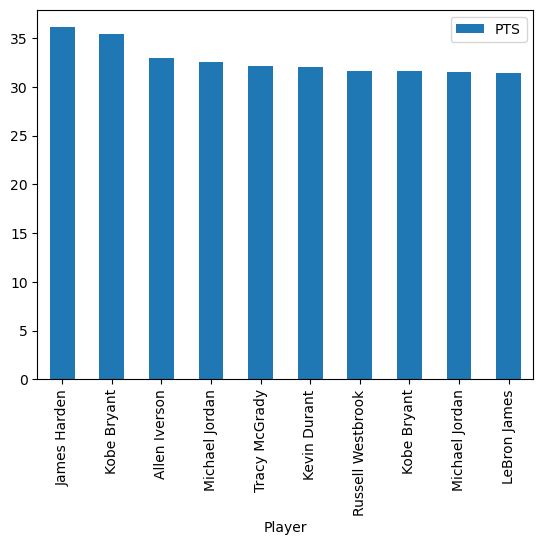

In [163]:
highest_scoring.plot.bar("Player","PTS")

<AxesSubplot:xlabel='Year'>

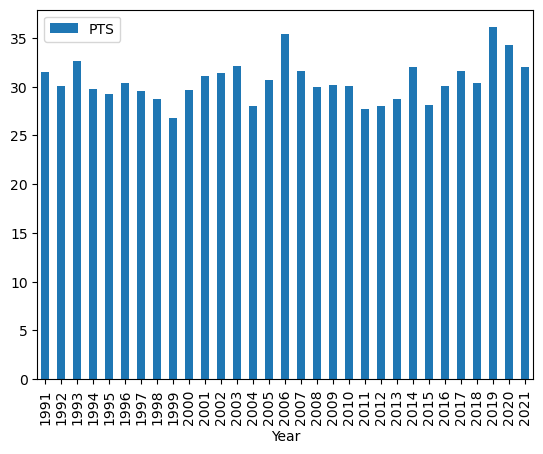

In [166]:
highest_score_year = stats.groupby(["Year"]).apply(lambda x : x.sort_values("PTS", ascending=False).head(1))
highest_score_year.plot.bar("Year","PTS")

<AxesSubplot:>

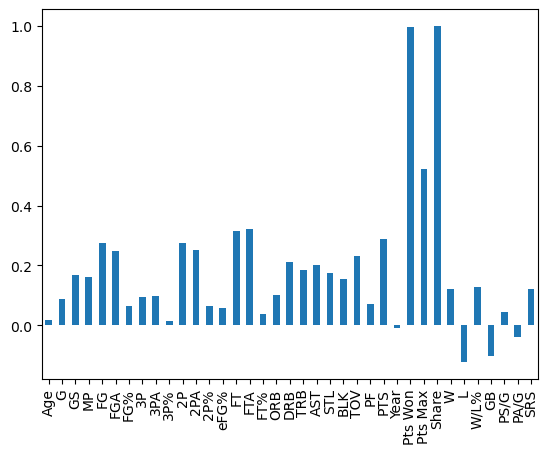

In [172]:
stats.corr()["Share"].plot.bar()